# Imports

In [1]:
%cd ..

import sys
import os
from agents import *
from main import *

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_portfolio import StockPortfolioEnv

from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models

import pyfolio
from pyfolio import timeseries

from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

%cd ./notebook

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)



INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


C:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
c:\Users\oscar\Github\Github\Research-project\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Download and process data

In [2]:
df = YahooDownloader(start_date = '2008-01-01',
                     end_date = '2021-07-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Prepare environment

In [3]:
train = data_split(df, '2009-01-01','2020-07-01')

stock_dimension = len(train.tic.unique())
state_space = stock_dimension

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

env_train, obs = e_train_gym.get_sb_env()

# Train agent

In [7]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 5000, "learning_rate": 0.001}

model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=500)

{'batch_size': 128, 'buffer_size': 5000, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/ddpg\ddpg_4
begin_total_asset:1000000
end_total_asset:5463279.268632796
Sharpe:  0.8955494346381272


### Test Agent

In [8]:
trade = data_split(df,'2020-07-01', '2021-07-01')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)



DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")


#baseline stats
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])
print("==============Get Baseline Stats===========")
stats = backtest_stats(baseline_df, value_col_name = 'close')

print("==============DRL Strategy Stats===========")
print(perf_stats_all)

begin_total_asset:1000000
end_total_asset:1397274.519672615
Sharpe:  2.2688063692708784
hit end!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 8)
==============Get Baseline Stats===========
Annual return          0.328495
Cumulative returns     0.328495
Annual volatility      0.145802
Sharpe ratio           2.029734
Calmar ratio           3.678238
Stability              0.946024
Max drawdown          -0.089308
Omega ratio            1.402310
Sortino ratio          3.037265
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.080042
Daily value at risk   -0.017195
dtype: float64
==============DRL Strategy Stats===========
Annual return          0.397275
Cumulative returns     0.397275
Annual volatility      0.152652
Sharpe ratio           2.268806
Calmar ratio           4.105133
Stability              0.942285
Max drawdown          -0.096775
Omega ratio            1.460487
Sortino ratio          3.5435

### Plot test results

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-07-01
End date,2021-06-30
Total months,12
,Backtest
Annual return,39.727%
Cumulative returns,39.727%
Annual volatility,15.265%
Sharpe ratio,2.27
Calmar ratio,4.11
Stability,0.94
Max drawdown,-9.678%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.68,2020-09-02,2020-10-28,2020-11-09,49
1,4.05,2021-01-20,2021-01-29,2021-02-05,13
2,3.64,2021-06-04,2021-06-18,NaT,NaN
3,3.15,2021-05-07,2021-05-12,2021-06-04,21
4,3.13,2020-07-22,2020-07-31,2020-08-06,12


C:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\tools.py:395: MatplotlibDeprecationWarning: 
The is_last_row function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_last_row() instead.
  if ax.is_last_row():
C:\Users\oscar\AppData\Local\Programs\Py

Stress Events,mean,min,max
New Normal,0.14%,-3.62%,4.52%


C:\Users\oscar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


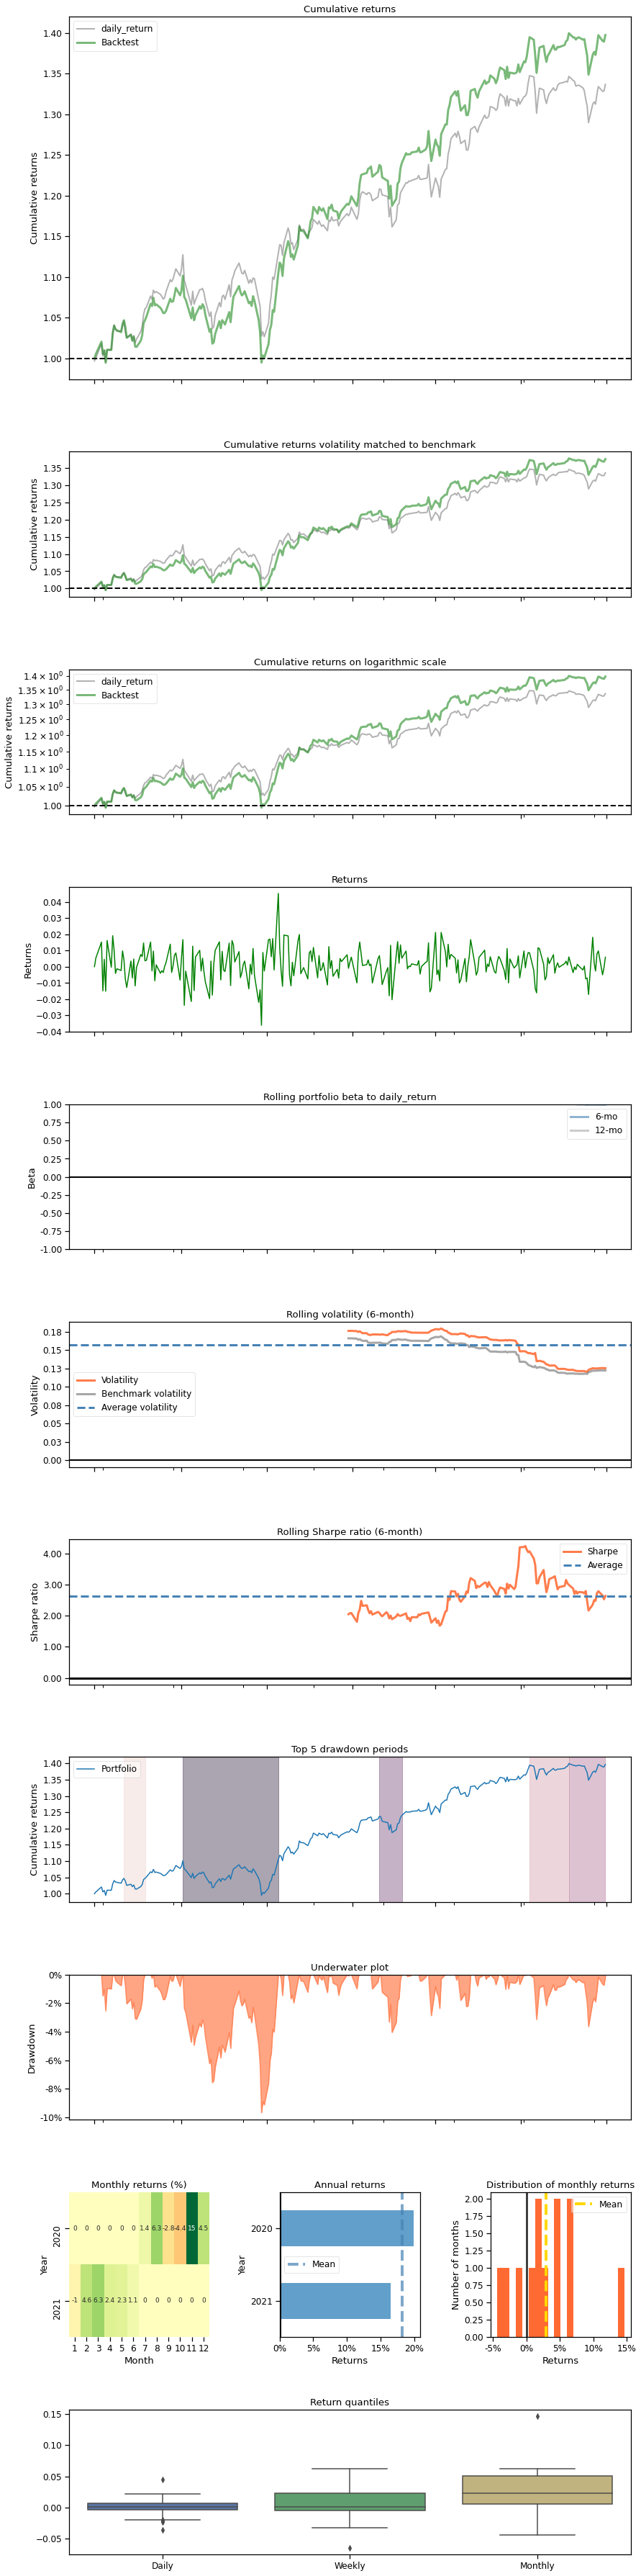

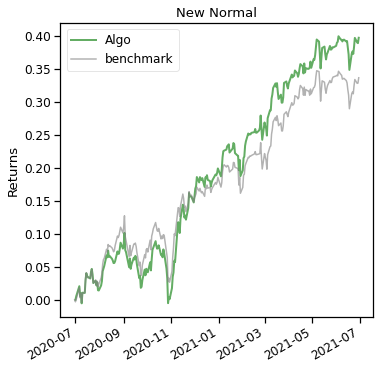

In [9]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-07-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat, benchmark_rets=baseline_returns, set_context=False)

### Min Var plot (BROKEN)

In [ ]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

time_ind = pd.Series(df_daily_return.date)
td3_cumpod =(df_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1

trace0_portfolio = go.Scatter(x = time_ind, y = td3_cumpod, mode = 'lines', name = 'TD3 (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')


fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()